In [21]:
import glob
import pandas as pd
import numpy as np
import pickle
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

import random


In [22]:
f_list = glob.glob('*_data_df.p')
df_list = []
for fname in f_list:
    if 'jupyter' not in fname:
        #if 'guard' in fname:
        df_list.append(pickle.load(open( fname, 'rb' )))
#print(df_list[5])

In [23]:
#print(df_list)
full_feature_df = pd.concat(df_list)
#print(full_feature_df)
print(list(full_feature_df))

['label', 'word_count', 'sent_len', 'word_len', 'sent_len_std', 'unique_word_frac', 'cps', 'qps', 'exps', 'adverbs', 'verbs', 'adjectives', 'foreign', 'flesch', 'said_ps', 'and_ps', 'but_ps', 'flesch_five', 'flesch_sec', 'total_adv', 'total_verb', 'total_adj', 'sent_count', 'adv_ps', 'verb_ps', 'adj_ps', 'RB_ps', 'RBR_ps', 'RBS_ps', 'WRB_ps', 'VB_ps', 'VBD_ps', 'VBG_ps', 'VBN_ps', 'VBP_ps', 'VBZ_ps', 'JJ_ps', 'JJS_ps', 'JJR_ps', 'told_ps']


In [10]:
full_feature_df = full_feature_df.loc[full_feature_df['flesch_five'] > 0]

In [40]:
full_feature_df['sent_len_mean_over_std'] = full_feature_df['sent_len']/full_feature_df['sent_len_std']
full_feature_df = full_feature_df.loc[(full_feature_df['sent_len_std'] > 0) & ]

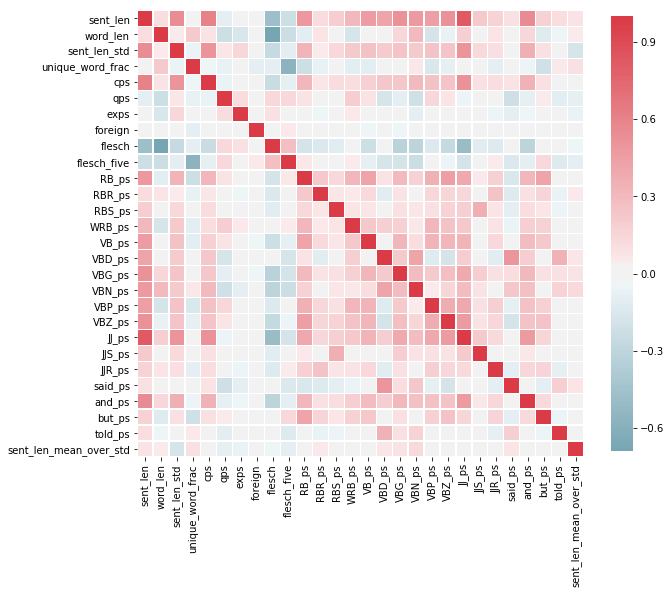

In [41]:
feat_list = ['sent_len', 'word_len', 'sent_len_std', 'unique_word_frac', 
             'cps', 'qps', 'exps', 'foreign', 'flesch',  'flesch_five',
             'RB_ps', 'RBR_ps', 'RBS_ps', 'WRB_ps', 'VB_ps', 
             'VBD_ps', 'VBG_ps', 'VBN_ps', 'VBP_ps', 'VBZ_ps', 'JJ_ps', 'JJS_ps', 'JJR_ps',
             'said_ps', 'and_ps', 'but_ps', 'told_ps', 'sent_len_mean_over_std']

#full_feature_df = pd.concat(df_list)



import matplotlib.ticker as ticker
corr = full_feature_df[feat_list].corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.figure(figsize=(10,10))
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,cmap=cmap, center=0,
            square=True, linewidths=.3, cbar_kws={"shrink": .8})




full_feature_df[feat_list].head()

min_word_count = 0

feature_array = full_feature_df.loc[(full_feature_df['word_count'] > min_word_count)][feat_list].values
label_array =   full_feature_df.loc[(full_feature_df['word_count'] > min_word_count)]['label'].values
#print(full_feature_df[feat_list][(full_feature_df >= 0).all(1)].head())

article_counts = full_feature_df.groupby('label')['label'].count().tolist()
class_names = [i.loc[0,'label'] for i in df_list]

In [42]:
#combine features
#X = [[i, j, k, l, m, n, o] for i, j, k, l, m, n, o in zip(
#    sent_len_std, unique_word_frac, word_len, cps, qps, exps, flesch)]#, sup_adv_ps, verb_ps, sent_compound)]
#feature_names = ['sentence variability', 'unique word fraction', 
#                 'mean word length', 'commas per sentence', 'questions per sentence', 
#                 'exclamations per sentence', 'flesch']#, 'adverbs per sentence', 
                 #'verbs per sentence', 'sent_compound']



X = feature_array
feature_names = feat_list
Y = label_array

n_samples = len(X)

data_boundaries = article_counts
#data_boundaries = [n_articles for i in [nyt, breit, wapo, guard]]
print(data_boundaries)
print(class_names)
cumulative_bounds = [0]
for ci, i in enumerate(data_boundaries):
    cumulative_bounds.append(i+cumulative_bounds[ci])
print(cumulative_bounds)
#cumulative_bounds = [0]
#cumulative_bounds = [cumulative_bounds[i-1] + i for i in data_boundaries]
print(len(X))
#X = np.asarray(wc).reshape(-1,1)

#labels
#Y = [0 for i in range(len(nyt_feature_df.word_count))] + \
#    [1 for i in range(len(breit_feature_df.word_count))] + \
#    [2 for i in range(len(wapo_feature_df.word_count))] + \
#    [3 for i in range(len(guard_feature_df.word_count))]
#Y = [0 for i in range(n_articles)] + [1 for i in range(n_articles)] + [2 for i in range(n_articles)] + [3 for i in range(n_articles)]
print(len(Y))


[4989, 4919, 4835, 4348, 4884, 4943, 4976, 4947, 4956]
['nyt', 'atl', 'fox', 'natrev', 'breit', 'wapo', 'buzz', 'vox', 'guard']
[0, 4989, 9908, 14743, 19091, 23975, 28918, 33894, 38841, 43797]
43797
43797


In [43]:
#test train split
from sklearn.model_selection import train_test_split

indices = np.arange(n_samples)

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, Y, indices, test_size=0.1)
print(idx_train)
print(idx_test)

#text_list = nyt_sent + breit_sent + wapo_sent +guard_sent
#print(len(text_list))

[ 3164 21613  2513 ... 41066 38776  3372]
[21913 39457 38682 ... 21692 16340 30394]


In [64]:
#pca

from sklearn.decomposition import PCA
pca = PCA(n_components=15)
pca.fit(X)

print(pca.explained_variance_ratio_)  

print(pca.singular_values_)  

[8.68e-01 7.16e-02 4.05e-02 1.87e-02 2.14e-04 1.86e-04 1.39e-04 6.63e-05
 5.26e-05 4.24e-05 3.51e-05 2.87e-05 2.67e-05 2.41e-05 1.89e-05]
[7735.19 2221.2  1669.66 1136.44  121.52  113.22   97.77   67.57   60.18
   54.03   49.18   44.46   42.91   40.73   36.09]


In [15]:
#rf with pca

X_t_train = pca.transform(X_train)
X_t_test = pca.transform(X_test)

from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=30)
for i in range(100,4500, 400):
    rand_start = random.randint(0,4500 - i)
    rf_clf = rf_clf.fit(X_t_train[rand_start:rand_start + i], y_train[rand_start:rand_start + i])

    print(rf_clf.score(X_t_test, y_test))
rf_clf = rf_clf.fit(X_t_train, y_train)
print(rf_clf.score(X_t_test, y_test))

y_pred = rf_clf.predict(X_t_test)
#chance = [0 if random.random() > 0.5 else 1 for _ in range(len(y_pred))]

NameError: name 'pca' is not defined

In [27]:
#from sklearn.model_selection import GridSearchCV
#parameters = {'max_depth':range(3,20)}
#clf = GridSearchCV(tree.DecisionTreeClassifier(), parameters, n_jobs=4)
#clf.fit(X=X_train, y=y_train)
#tree_model = clf.best_estimator_
#print (clf.best_score_, clf.best_params_) 


#clf = tree.DecisionTreeClassifier(max_depth = 5)
#clf = clf.fit(X_train, y_train)

from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=30)
for i in range(100,4500, 400):
    rand_start = random.randint(0,4500 - i)
    rf_clf = rf_clf.fit(X_train[rand_start:rand_start + i], y_train[rand_start:rand_start + i])

    print(rf_clf.score(X_test, y_test))
rf_clf = rf_clf.fit(X_train, y_train)
print(rf_clf.score(X_test, y_test))

y_pred = rf_clf.predict(X_test)
#chance = [0 if random.random() > 0.5 else 1 for _ in range(len(y_pred))]

0.236986301369863
0.3207762557077626
0.34383561643835614
0.36552511415525113
0.36004566210045663
0.3627853881278539
0.36552511415525113
0.3819634703196347
0.38447488584474887
0.3910958904109589
0.39429223744292236
0.4415525114155251


In [44]:
from sklearn.ensemble import GradientBoostingClassifier

xg_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.25,
                                 max_depth=6, random_state=0).fit(X_train, y_train)
print(xg_clf.score(X_test, y_test))

y_pred = xg_clf.predict(X_test)


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

Normalized confusion matrix
[[0.44 0.06 0.05 0.03 0.07 0.13 0.07 0.1  0.06]
 [0.03 0.5  0.09 0.12 0.06 0.07 0.03 0.03 0.06]
 [0.03 0.15 0.43 0.09 0.1  0.02 0.05 0.04 0.08]
 [0.04 0.17 0.09 0.43 0.1  0.04 0.04 0.03 0.07]
 [0.09 0.06 0.12 0.09 0.32 0.07 0.07 0.08 0.1 ]
 [0.12 0.04 0.02 0.01 0.05 0.54 0.01 0.12 0.09]
 [0.06 0.03 0.03 0.02 0.07 0.02 0.67 0.02 0.07]
 [0.09 0.06 0.04 0.02 0.04 0.12 0.01 0.55 0.07]
 [0.09 0.07 0.09 0.07 0.05 0.13 0.08 0.08 0.33]]


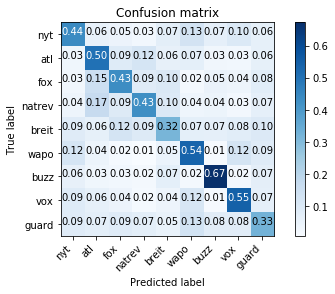

In [31]:
from sklearn.metrics import confusion_matrix
import itertools
#New York Times', 'Breitbart', 'Washington Post', 'Guardian']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha = 'right')
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix', normalize = True)


Feature ranking:
1. feature 3 (0.076518)
2. feature 1 (0.057807)
3. feature 23 (0.055074)
4. feature 2 (0.054642)
5. feature 4 (0.050590)
6. feature 0 (0.047938)
7. feature 9 (0.045915)
8. feature 8 (0.045589)
9. feature 15 (0.043678)
10. feature 10 (0.041692)
11. feature 19 (0.039916)
12. feature 14 (0.038785)
13. feature 17 (0.038487)
14. feature 18 (0.037535)
15. feature 20 (0.036675)
16. feature 16 (0.034460)
17. feature 24 (0.033584)
18. feature 25 (0.029403)
19. feature 13 (0.027753)
20. feature 22 (0.027295)
21. feature 11 (0.025852)
22. feature 21 (0.023885)
23. feature 5 (0.023318)
24. feature 26 (0.022754)
25. feature 12 (0.017679)
26. feature 6 (0.013239)
27. feature 7 (0.009934)
[ 3  1 23  2  4  0  9  8 15 10 19 14 17 18 20 16 24 25 13 22 11 21  5 26
 12  6  7]


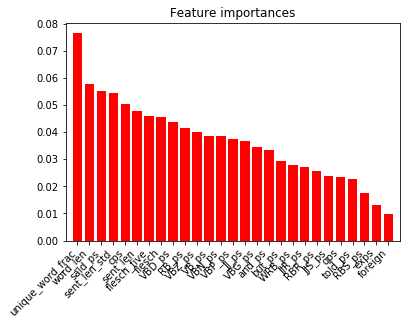

In [32]:
importances = xg_clf.feature_importances_
#std = np.std([tree.feature_importances_ for tree in xg_clf.estimators_],
#             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(len(X[0])):#.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

    # Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(X[0])), importances[indices],
       color="r", align='center')#, yerr=std[indices], align="center")
print(indices)
plt.xticks(range(len(X[0])), [feature_names[i] for i in indices], rotation = 45, ha = 'right')
plt.xlim([-1, len(X[0])])
plt.show()

In [ ]:
conf_mat = np.zeros((4,4))
count = 0
for pred, true in zip(y_pred, y_test):
    if pred == 0 and true == 3:
            print(pred, true, count, 'mismatch')
            print(' '.join(text_list[idx_test[count]]))
            input()
    conf_mat[pred,true] += 1.
    count += 1
print(count)
#conf_mat[2,1] += 1000
#[y,x] format (first index (predicted) is on the vertical, second index (truth) is on the horizontal)
plt.imshow(conf_mat)
plt.colorbar()
print(conf_mat, np.sum(conf_mat))
print(Counter(y_test))